# 13주 iris 데이터 회귀 분석

앞서 사용했던 iris데이터를 사용해서 회귀분석을 해보자.

iris데이터는 아래 URL에서 읽어올 수 있다.



```

import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

```

### (1) DataFrame 생성

In [61]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# pandas DataFrame
iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [63]:
import pyspark

spark = pyspark.sql.SparkSession\
    .builder\
    .master('local')\
    .appName('AssignmentWeek13')\
    .config(conf=pyspark.SparkConf())\
    .getOrCreate()

In [64]:
# spark DataFrame
irisDf = spark.createDataFrame(iris)

irisDf.printSchema()
irisDf.show()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|
|         4.9

## (2) 회귀선 그래프

In [65]:
from sklearn.model_selection import train_test_split

# using pandas DataFrame
train, test = train_test_split(iris, train_size=0.8)

Xtrain = train.drop(['sepal_length', 'sepal_width', 'petal_width', 'species'], axis=1)
ytrain = train['petal_width']
Xtest = test.drop(['sepal_length', 'sepal_width', 'petal_width', 'species'], axis=1)
ytest = test['petal_width']

In [66]:
from sklearn.linear_model import LinearRegression

regresstion = LinearRegression()
trainModel = regresstion.fit(Xtrain, ytrain)

In [68]:
trainModel.coef_, trainModel.intercept_

(array([0.41187406]), -0.3602126475364218)

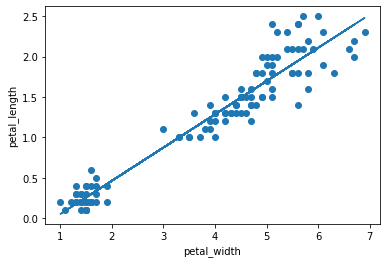

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

ypred = trainModel.predict(Xtrain)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Xtrain,ytrain)
ax.set_ylabel('petal_length') 
ax.set_xlabel('petal_width')
ax.plot(Xtrain,ypred)

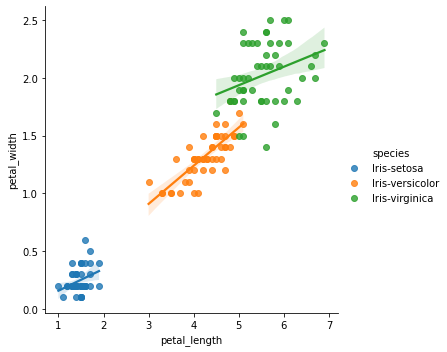

In [70]:
import seaborn as sns

sns.lmplot(x="petal_length", y="petal_width", data=iris, hue='species')

## (3) Spark를 사용하여 회귀 분석하고 계수 출력

In [71]:
trainDf, testDf = irisDf.randomSplit([0.8, 0.2])

In [72]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [73]:
va = VectorAssembler(inputCols=['petal_length'], outputCol='features')
lr = LinearRegression(featuresCol='features', labelCol='petal_width')
pipeline = Pipeline(stages=[va, lr])

model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)
modelTestDf = model.transform(testDf)
modelTestDf.select(['petal_length', 'petal_width', 'prediction']).show()

21/11/27 17:05:16 WARN Instrumentation: [aafd3b96] regParam is zero, which might cause numerical instability and overfitting.


+------------+-----------+-------------------+
|petal_length|petal_width|         prediction|
+------------+-----------+-------------------+
|         1.3|        0.2|0.17773410838315312|
|         1.3|        0.2|0.17773410838315312|
|         1.4|        0.1|0.21914930093891422|
|         1.6|        0.2| 0.3019796860504366|
|         1.4|        0.2|0.21914930093891422|
|         1.5|        0.1| 0.2605644934946754|
|         1.6|        0.4| 0.3019796860504366|
|         1.6|        0.6| 0.3019796860504366|
|         1.7|        0.5| 0.3433948786061977|
|         1.4|        0.2|0.21914930093891422|
|         1.5|        0.3| 0.2605644934946754|
|         1.6|        0.2| 0.3019796860504366|
|         3.9|        1.4| 1.2545291148329434|
|         1.7|        0.4| 0.3433948786061977|
|         1.4|        0.2|0.21914930093891422|
|         5.0|        2.0|  1.710096232946316|
|         3.5|        1.0| 1.0888683446098986|
|         4.5|        1.3| 1.5030202701675104|
|         4.2

In [74]:
irisTest = modelTestDf.select(['petal_length', 'petal_width', 'prediction']).toPandas()

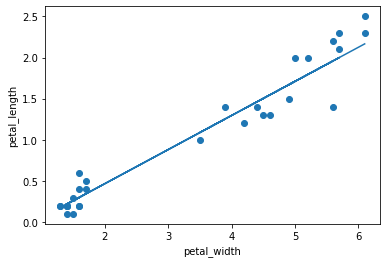

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(irisTest['petal_length'], irisTest['petal_width'])
ax.set_ylabel('petal_length') 
ax.set_xlabel('petal_width')
ax.plot(irisTest['petal_length'], irisTest['prediction'])

In [76]:
print(f"Coefficient: {model.stages[-1].coefficients}")
print(f"Intercept: {model.stages[-1].intercept}")

Coefficient: [0.41415192555761166]
Intercept: -0.3606633948417421


## (4) 실제와 예측 출력

In [53]:
irisTest[['petal_width', 'prediction']]

,petal_width,prediction
0,0.1,0.080928
1,0.2,0.206667
2,0.2,0.206667
3,0.2,0.164754
4,1.7,1.505970
5,1.0,1.086840
6,0.2,0.122841
7,0.2,0.206667
8,0.6,0.290493
9,0.2,0.206667


## (5) 정확성을 평가하고 출력

In [56]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='petal_width', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(modelTestDf)

print(f"r2: {rmse:.3f}")

r2: 0.224


In [77]:
spark.stop()